<a href="https://colab.research.google.com/github/kmaciver/Ryerson_Capstone/blob/master/Approach/Step3-DFSD/DailySummaryPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM, TimeDistributed, Lambda, Dropout
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import losses
import warnings
warnings.filterwarnings('ignore')
import random as rand
from random import randint
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [4]:
file_path = "/content/drive/My Drive/Capstone/Data Exploration/DSFD.csv"
DaySummary = pd.read_csv(file_path, index_col='date')
DaySummary = DaySummary.drop([DaySummary.columns[0]] ,  axis='columns')
DaySummary.head()

,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted_Price,RSI,MACD_sig,slow_stoch,Open_RoC,High_RoC,Low_RoC,Close_RoC,Weighted_Price_RoC
date,,,,,,,,,,,,,,,
2013-04-03,116.0,158.41,110.0,133.78,16468.610754,2.126462e+06,130.08716,43.384086,0.733919,0.271676,0.0,0.0,0.0,0.0,0.0
2013-04-04,116.0,158.41,110.0,133.78,16468.610754,2.126462e+06,130.08716,43.384086,0.733919,0.271676,0.0,0.0,0.0,0.0,0.0
2013-04-05,116.0,158.41,110.0,133.78,16468.610754,2.126462e+06,130.08716,43.384086,0.733919,0.271676,0.0,0.0,0.0,0.0,0.0
2013-04-06,116.0,158.41,110.0,133.78,16468.610754,2.126462e+06,130.08716,43.384086,0.733919,0.271676,0.0,0.0,0.0,0.0,0.0
2013-04-07,116.0,158.41,110.0,133.78,16468.610754,2.126462e+06,130.08716,43.384086,0.733919,0.271676,0.0,0.0,0.0,0.0,0.0


Dropping Volume Currency and Close_RoC as discussed in the Feature Selection phase

In [0]:
DaySummary = DaySummary.drop(columns=['Volume_Currency','Close_RoC'])

In [6]:
#We need create a target data, which is basically a copy of the data that will be later shifted
target_data = DaySummary.copy()
target_data = target_data.loc[:,['High','Low']]
target_data.tail()

,High,Low
date,,
2019-08-07,12145.42,11388.01
2019-08-08,12061.10,11450.93
2019-08-09,12040.00,11650.00
2019-08-10,11976.68,11200.00
2019-08-11,11589.73,11080.37


There are 2322 days between the initial day 2013-04-03 of the data up to the last day 2019-08-11

In [7]:
DaySummary.shape

(2322, 13)

The objective of the model is to predict the High and Low values of the following day

In [0]:
# Predict 1 day in the future
shift_steps = 1

# Now that the target_data was created we need to shift the data so that the target values of 1 day later aling with our
# input data

target_data = target_data.shift(-shift_steps)


Here we double check that because we shifted the target values now we have NaN values at the end

In [9]:
target_data.tail()

,High,Low
date,,
2019-08-07,12061.10,11450.93
2019-08-08,12040.00,11650.00
2019-08-09,11976.68,11200.00
2019-08-10,11589.73,11080.37
2019-08-11,NaN,NaN


In [0]:
# Now we need to remove the rows with NaN values for the target data thus needing to exclude also 
# 1 line of the DaySummary data

DaySummary_clean = DaySummary.iloc[:-1,:]
target_data_clean = target_data.iloc[:-1,:]

In [11]:
DaySummary_clean.shape, target_data_clean.shape

((2321, 13), (2321, 2))

Separating the days between test and training

In [0]:
# For the use of Neural Networks we need to convert the data to a numpy array

X_data = np.array(DaySummary_clean)
Y_data = np.array(target_data_clean)

In [13]:
# Using a 90% split of the data for validation

train_split = 0.9

n_train_rows = int(X_data.shape[0]*train_split)


# For validation since we are performing a sliding window it got to be an even number

X_train = X_data[0:n_train_rows]
X_test = X_data[n_train_rows:]
Y_train = Y_data[0:n_train_rows]
Y_test = Y_data[n_train_rows:]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(2088, 13) (2088, 2) (233, 13) (233, 2)


Now we need to Scale the data to feed it to the Neural Network

In [14]:
x_scaler = MinMaxScaler()

X_train_scale = x_scaler.fit_transform(X_train)
X_test_scale =  x_scaler.transform(X_test)

y_scaler = MinMaxScaler()

Y_train_scale = y_scaler.fit_transform(Y_train)
Y_test_scale =  y_scaler.transform(Y_test)

# For keras we data input has to have a (x,y,z) shape

X_train_scale = X_train_scale.reshape(1,X_train_scale.shape[0],X_train_scale.shape[1])
Y_train_scale = Y_train_scale.reshape(1,Y_train_scale.shape[0],Y_train_scale.shape[1])
X_test_scale  = X_test_scale.reshape(1,X_test_scale.shape[0],X_test_scale.shape[1])
Y_test_scale  = Y_test_scale.reshape(1,Y_test_scale.shape[0],Y_test_scale.shape[1])

print(X_train_scale.shape, Y_train_scale.shape, X_test_scale.shape, Y_test_scale.shape)

(1, 2088, 13) (1, 2088, 2) (1, 233, 13) (1, 233, 2)


In [0]:
def batch_reshape(sequence_length, X_train_scale, Y_train_scale, num_x_signal, num_y_signal):
    """
    Generator function for creating random batches of training-data.
    """
    batch_size = X_train_scale.shape[1] // sequence_length
   
    # Allocate a new array for the batch of input-signals.
    x_shape = (batch_size, sequence_length, num_x_signal)
    x_batch = np.zeros(shape=x_shape, dtype=np.float16)

    # Allocate a new array for the batch of output-signals.
    y_shape = (batch_size, num_y_signal)
    y_batch = np.zeros(shape=y_shape, dtype=np.float16)

    #print(x_batch.shape, y_batch.shape, X_train_scale.shape, Y_train_scale.shape) #debugging
    
    # Create Sequence for sliding window
    seq = []
    for i in range(batch_size):
        seq.append(i*sequence_length)

    # Fill the batch with sequences of data.
    for i in range(0,len(seq)-1):

        # Copy the sequences of data starting at this index.
        x_batch[i] = X_train_scale[0][seq[i]:seq[i]+sequence_length][:]
        y_batch[i] = Y_train_scale[0][seq[i]+sequence_length-1][:]
        #print("iteration: ",i,"-OK") #debugging
    
    #print(x_batch.shape,y_batch.shape) #debbuging
    return (x_batch, y_batch)

In [0]:
def batch_generator(batch_size, sequence_length, num_x_signal, num_y_signal,  X_train_scale, Y_train_scale):
    
    X_reshaped , Y_reshaped =  batch_reshape(sequence_length, X_train_scale, Y_train_scale, num_x_signal, num_y_signal)
    
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signal)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, num_y_signal)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random continuous sequences of data.

        # Get a random start-index.
        # This points somewhere into the training-data.
        idx = np.random.randint(X_reshaped.shape[0] - batch_size)

        # Copy the sequences of data starting at this index.
        x_batch = X_reshaped[idx:idx+batch_size]
        y_batch = Y_reshaped[idx:idx+batch_size]

        
        yield (x_batch, y_batch)
        

In [0]:
num_x_signal = 13 # number of input features
num_y_signal = 2 # number of label classes

batch_size = 60 # tunning parameter
sequence_length = 25 #Amount of time-steps to look back for the 10 minute prediction

In [0]:
generator = batch_generator(batch_size,sequence_length, num_x_signal, num_y_signal, X_train_scale, Y_train_scale)

In [19]:
x_batch, y_batch = next(generator)

print(x_batch.shape, y_batch.shape)

(60, 25, 13) (60, 2)


In [0]:
def batch_validation(sequence_length, num_x_signal, num_y_signal, X_test_scale, Y_test_scale):
    """
    Generator function for creating random batches of validation data.
    """
    # Allocate a new array for the batch of input-signals.
    batch_size_val = X_test_scale.shape[1] - sequence_length 

    x_shape = (batch_size_val, sequence_length, num_x_signal)
    x_batch = np.zeros(shape=x_shape, dtype=np.float16)

    # Allocate a new array for the batch of output-signals.
    y_shape = (batch_size_val, num_y_signal)
    y_batch = np.zeros(shape=y_shape, dtype=np.float16)

    # Fill the batch with random sequences of data.
    for i in range(batch_size_val):

        # Copy the sequences of data starting at this index.
        x_batch[i] = X_test_scale[0][i:i+sequence_length][:]
        y_batch[i] = Y_test_scale[0][i+sequence_length-1][:]


    return (x_batch, y_batch)

In [21]:
X_val, Y_val = batch_validation(sequence_length,num_x_signal, num_y_signal, X_test_scale, Y_test_scale)
print(X_val.shape, Y_val.shape)

(208, 25, 13) (208, 2)


In [0]:
validation_data = (X_val, Y_val)

## Create Recurrent Neural Network

In [24]:
from tensorflow.keras.layers import BatchNormalization
#from keras.constraints import max_norm

model = Sequential()
model.add(LSTM(units=200,
              return_sequences=True,
              input_shape=(None,num_x_signal,)))
model.add(LSTM(units=150, return_sequences=False))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(num_y_signal,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 200)         171200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               210600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150)               600       
_________________________________________________________________
dense (Dense)                (None, 2)                 302       
Total params: 382,702
Trainable params: 382,402
Non-trainable params: 300
_________________________________________________________________


In [0]:
optimizer = Adam(lr=1e-3)

model.compile(loss=losses.logcosh, optimizer=optimizer)

model.save_weights('initial_weights.h5')

In [0]:
#es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-6)

model_file = "DailySummary_LSTM 2 layers_Relu_MinMax_Modified_LogCosh.h5"

mc = ModelCheckpoint(model_file, monitor="val_loss", mode="min", save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=1e-4)

In [0]:
%%time
model.load_weights('initial_weights.h5')

history = model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=50,
                    validation_data=validation_data,
                    callbacks=[ mc, reduce_lr])
                    #callbacks=[es, reduce_lr])

In [0]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = model_file.split('.')[0]+'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [0]:
# Save history and H5 file to drive
saveDrivePath = '/content/drive/My Drive/Capstone/Approach/Step3DailySummary/Best_model'
h5FilePath = '/content/'+ model_file
historyFilePath = '/content/' + hist_csv_file
initialWeightsFilePath = '/content/initial_weights.h5'

os.system("mv "+'"'+h5FilePath+'"' + " " + '"'+saveDrivePath+'"' )
os.system("mv "+'"'+historyFilePath+'"' + " " + '"'+saveDrivePath+'"' )
os.system("mv "+'"'+initialWeightsFilePath+'"' + " " + '"'+saveDrivePath+'"' )

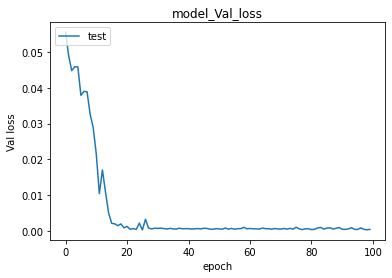

In [30]:
plt.plot(history.history['val_loss'])
plt.title('model_Val_loss')
plt.ylabel('Val loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

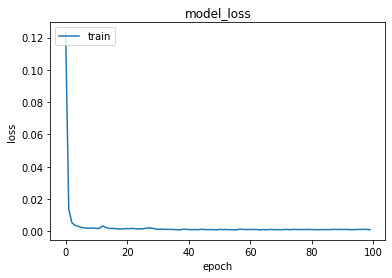

In [31]:
plt.plot(history.history['loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [32]:
# The algorithm uses data of the previous 25 time-steps to forecast the following day into the future. 

#Create a Dataframe to hold the true predicted values for each day.
DailySummaryPredictionData = DaySummary.copy()
DailySummaryPredictionData = DailySummaryPredictionData.loc[:,['High','Low']]
DailySummaryPredictionData = DailySummaryPredictionData[:-1]
DailySummaryPredictionData = DailySummaryPredictionData[n_train_rows:]# Filter only the testing days
DailySummaryPredictionData = DailySummaryPredictionData[25:]
DailySummaryPredictionData.shape

(208, 2)

In [0]:
def predict(modelFilename, predictionsData):

    column_name = modelFilename.split('.')[0]
    #Step 1 - Create the columns to hold predictions

    predictionsData[column_name + "_High"] = np.nan
    predictionsData[column_name + "_Low"] = np.nan
    
    #Step 2 - load model for prediction   
    loaded_model = model
    
    #Step39 - Generate the prediction   
    ypred = loaded_model.predict(X_val)
    ypred_rescaled = y_scaler.inverse_transform(ypred)

    #Step 10 - Copy the prediction values to the correspondent day in the predictionData
    predictionsData[column_name + "_High"] = ypred_rescaled[:,0]
    predictionsData[column_name + "_Low"] = ypred_rescaled[:,1]
    
    return(predictionsData)

In [0]:
modelfilePath = saveDrivePath + '/' + model_file

In [0]:
predict(modelfilePath, DailySummaryPredictionData)

In [0]:
prediction_file = 'predictions_' +  model_file.split('.')[0] + '.csv'
prediction_filePath = '/content/' + prediction_file
DailySummaryPredictionData.to_csv(prediction_file)

In [0]:
destinantionDir = '/content/drive/My Drive/Capstone/Approach/Step3DailySummary/Predictions_csv/Best_model'
oscmd = "mv "+'"'+prediction_filePath+'"' + " " + '"'+destinantionDir+'"' 
oscmd

In [0]:
os.system(oscmd)

In [0]:
DailySummaryPredictionData.head()

In [40]:
from sklearn.metrics import mean_squared_error

mse_High = mean_squared_error(DailySummaryPredictionData.iloc[:,0],DailySummaryPredictionData.iloc[:,2])
mse_High

243646.92714078602

In [41]:
mse_Low = mean_squared_error(DailySummaryPredictionData.iloc[:,1],DailySummaryPredictionData.iloc[:,3])
mse_Low

314755.28389723063